# Variational Autoencoder (VAE)

Useful links:
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this homework we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset [http://vis-www.cs.umass.edu/lfw/](http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


## Prepare the data

In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.initializers as I
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# The following code fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset

data, attrs = fetch_lfw_dataset()

In [3]:
print(attrs.shape)
print(data.shape)
attrs.head()

(13143, 73)
(13143, 45, 45, 3)


,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.568346,-1.889043,1.737203,-0.929729,-1.471799,-0.19558,-0.835609,-0.351468,-1.012533,-0.719593,...,0.361738,1.166118,-1.164916,-1.13999,-2.371746,-1.299932,-0.414682,-1.144902,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.282184,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,...,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.006244,-0.030406,-0.480128,0.66676,-0.496559
2,0.997749,-1.364195,-0.157377,-0.756447,-1.891825,-0.871526,-0.862893,0.031445,-1.341523,-0.090037,...,1.549743,1.884745,-0.999765,-1.359858,-1.912108,-1.095634,0.915126,-0.572332,0.144262,-0.841231
3,1.122719,-1.997799,1.916144,-2.514214,-2.580071,-1.404239,0.057551,0.000196,-1.273512,-1.431462,...,0.567822,-0.176089,1.108125,-1.600944,-3.264613,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.078214,-2.008098,1.676211,-2.278056,-2.651845,-1.348408,0.649089,0.017656,-1.889111,-1.857213,...,-1.461474,-0.955283,0.119113,-1.128176,-3.161048,0.08268,-0.439614,-0.359859,-0.760774,-0.410152


In [4]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 6075)
(3143, 6075)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [5]:
X_train = np.float32(X_train)
X_train = X_train/255
X_val = np.float32(X_val)
X_val = X_val/255

In [ ]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

In [ ]:
plot_gallery(X_train, image_h, image_w)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

<img src="Autoencoder_structure.png" alt="Autoencoder">

In [6]:
dimZ = 100 # Considering face reconstruction task, which size of representation seems reasonable?

# You can define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics

# However, you can just have 1 fc layer in each network without any activation,
# and it will also show some results

vanila_encoder = tf.keras.Sequential()
vanila_encoder.add(L.Dense(4*dimZ, activation='relu', kernel_initializer=I.GlorotUniform()))
vanila_encoder.add(L.Dense(dimZ, kernel_initializer=I.GlorotUniform()))
vanila_decoder = tf.keras.Sequential()
vanila_decoder.add(L.Dense(4*dimZ, activation='relu', kernel_initializer=I.GlorotUniform()))
vanila_decoder.add(L.Dense(X_train.shape[1], activation='sigmoid', kernel_initializer=I.GlorotUniform()))

model = tf.keras.Sequential()
model.add(vanila_encoder)
model.add(vanila_decoder)

In [7]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, rate):
        super(DisplayCallback, self).__init__()
        self.model = model
        self.rate = rate

    def on_epoch_end(self, epoch, logs=None):
        model = self.model
        if epoch % self.rate == 0:
            idx = np.random.choice(X_train.shape[0])
            plt.subplot(221)
            plt.imshow(X_train[idx].reshape(
                (image_h, image_w, 3)
            ))
            plt.subplot(222)
            plt.imshow(tf.reshape(
                model(X_train[tf.newaxis, idx]), (image_h, image_w, 3)
            ))
            idx = np.random.choice(X_val.shape[0])
            plt.subplot(223)
            plt.imshow(X_val[idx].reshape(
                (image_h, image_w, 3)
            ))
            plt.subplot(224)
            plt.imshow(tf.reshape(
                model(X_val[tf.newaxis, idx]), (image_h, image_w, 3)
            ))
            plt.show()

In [ ]:
|# Create MSE loss function
loss = tf.keras.losses.MeanSquaredError()
# Use Adam optimizer
opt = tf.keras.optimizers.Adam()
model.compile(loss=loss, optimizer=opt)
callback = DisplayCallback(model, 10)

In [ ]:
# Train your autoencoder
# Visualize progress in reconstruction and loss decay
history = model.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    callbacks=[callback],
    batch_size=50,
    epochs=100
)

In [ ]:
plt.plot(np.arange(100), history.history['loss'])
plt.plot(np.arange(100), history.history['val_loss'])
plt.show()

Reconstruction is not bad, right?

# Sampling

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

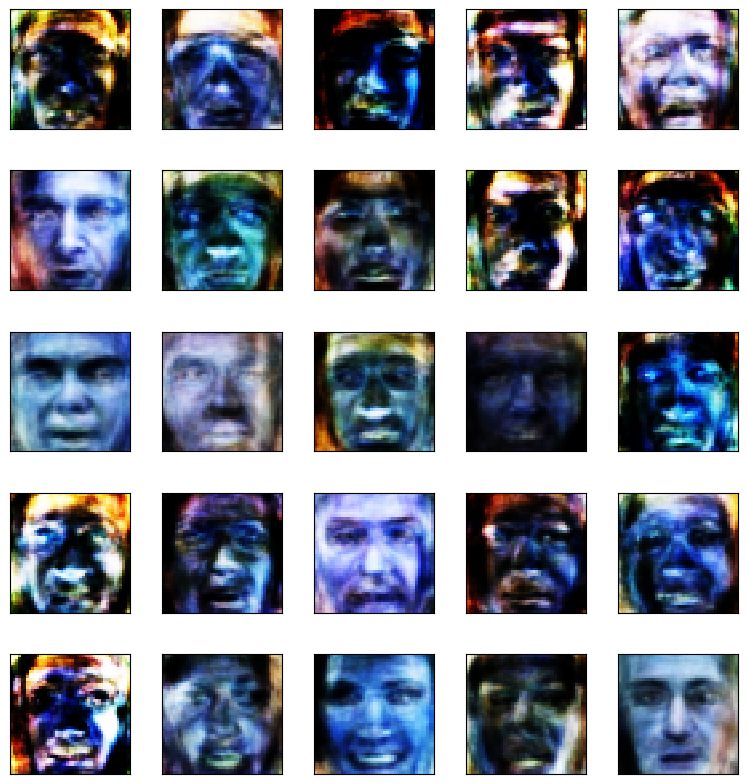

In [15]:
z = np.random.randn(25, dimZ) * 2
output = vanila_decoder(z).numpy()
plot_gallery(output, image_h, image_w, n_row=5, n_col=5)

So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler**, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [8]:
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimZ = 100

# define the network
# you can start from pytorch example https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST
class Sampling(L.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(z_log_var) * epsilon

enc_inp = L.Input(
    shape=(image_h * image_w * 3,),
    name='encoder_input'
)
encoding = L.Dense(
    units=dimZ,
    name='encoding'
)(enc_inp)
mean = L.Dense(
    units=dimZ,
    name='mean'
)(encoding)
log_var = L.Dense(
    units=dimZ,
    name='log_var'
)(encoding)
sample = Sampling(name='sample')([mean, log_var])
encoder = tf.keras.Model(enc_inp, [mean, log_var, sample])

dec_inp = L.Input(
    shape=(dimZ,),
    name='decoder_input'
)
decoding = L.Dense(
    units=image_h * image_w * 3,
    activation='sigmoid',
    name='decoding'
)(dec_inp)
decoder = tf.keras.Model(dec_inp, decoding)

encoder.summary()
decoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 6075)]       0           []                               
                                                                                                  
 encoding (Dense)               (None, 100)          607600      ['encoder_input[0][0]']          
                                                                                                  
 mean (Dense)                   (None, 100)          10100       ['encoding[0][0]']               
                                                                                                  
 log_var (Dense)                (None, 100)          10100       ['encoding[0][0]']               
                                                                                              

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)=...$$

In [9]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
            ]


    @tf.function
    def KL_divergence(self, mu, logsigma):
        return tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + logsigma - tf.square(mu) - tf.exp(logsigma)),
                axis=1
            )
        )

    @tf.function
    def log_likelihood(self, x, z):
        reconstruction = self.decoder(z)
        return tf.reduce_mean(
            tf.reduce_sum(
                tf.square(x-reconstruction), axis=-1
            )
        )

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction_loss = self.log_likelihood(data, z)
            kl_loss = self.KL_divergence(z_mean, z_log_var)
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        reconstruction_loss = self.log_likelihood(inputs, z)
        kl_loss = self.KL_divergence(z_mean, z_log_var)
        total_loss = reconstruction_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return reconstruction

In [10]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
callback = DisplayCallback(vae, 2)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

And train the model:

Epoch 1/50
 985/1000 [============================>.] - ETA: 0s - loss: 166.4829 - reconstruction_loss: 120.7172 - kl_loss: 45.7654

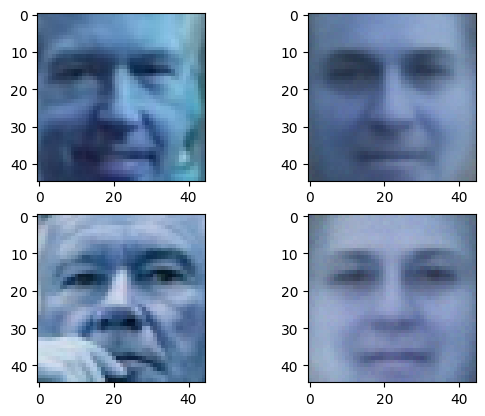

1000/1000 [==============================] - 8s 5ms/step - loss: 165.6465 - reconstruction_loss: 120.2007 - kl_loss: 45.4455 - val_loss: 112.3578 - val_reconstruction_loss: 87.4991 - val_kl_loss: 24.8587
Epoch 2/50
1000/1000 [==============================] - 4s 4ms/step - loss: 102.4771 - reconstruction_loss: 75.1436 - kl_loss: 27.3334 - val_loss: 89.0329 - val_reconstruction_loss: 62.5156 - val_kl_loss: 26.5173
Epoch 3/50
 992/1000 [============================>.] - ETA: 0s - loss: 88.5934 - reconstruction_loss: 62.8405 - kl_loss: 25.7528

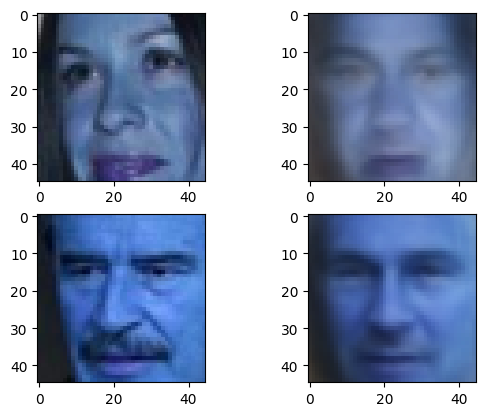

1000/1000 [==============================] - 4s 4ms/step - loss: 88.5281 - reconstruction_loss: 62.7891 - kl_loss: 25.7389 - val_loss: 75.8020 - val_reconstruction_loss: 54.0819 - val_kl_loss: 21.7201
Epoch 4/50
1000/1000 [==============================] - 4s 4ms/step - loss: 78.6132 - reconstruction_loss: 54.8492 - kl_loss: 23.7641 - val_loss: 74.1362 - val_reconstruction_loss: 49.4560 - val_kl_loss: 24.6801
Epoch 5/50
 992/1000 [============================>.] - ETA: 0s - loss: 73.5471 - reconstruction_loss: 51.0346 - kl_loss: 22.5125

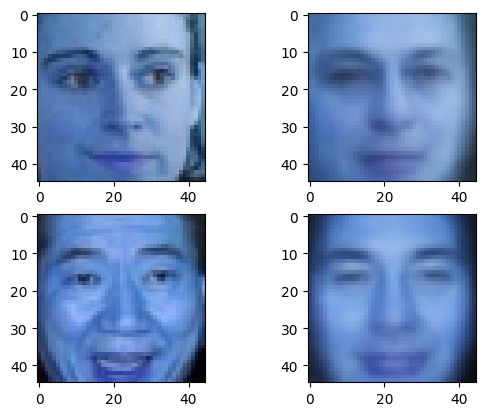

1000/1000 [==============================] - 4s 4ms/step - loss: 73.5032 - reconstruction_loss: 50.9962 - kl_loss: 22.5069 - val_loss: 68.5921 - val_reconstruction_loss: 47.3618 - val_kl_loss: 21.2303
Epoch 6/50
1000/1000 [==============================] - 4s 4ms/step - loss: 70.0598 - reconstruction_loss: 48.5344 - kl_loss: 21.5254 - val_loss: 66.3872 - val_reconstruction_loss: 46.8114 - val_kl_loss: 19.5758
Epoch 7/50
 987/1000 [============================>.] - ETA: 0s - loss: 68.8126 - reconstruction_loss: 47.9418 - kl_loss: 20.8709

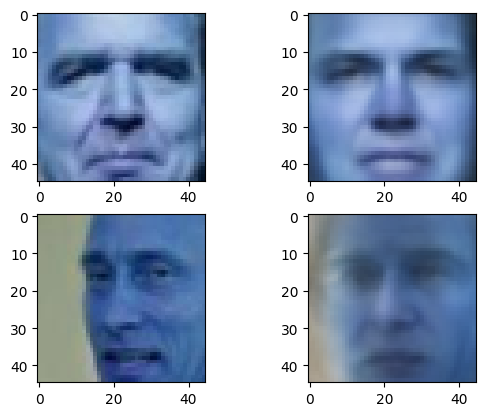

1000/1000 [==============================] - 5s 5ms/step - loss: 68.8017 - reconstruction_loss: 47.9339 - kl_loss: 20.8679 - val_loss: 64.6567 - val_reconstruction_loss: 44.5692 - val_kl_loss: 20.0875
Epoch 8/50
1000/1000 [==============================] - 4s 4ms/step - loss: 67.7706 - reconstruction_loss: 47.4854 - kl_loss: 20.2852 - val_loss: 65.9000 - val_reconstruction_loss: 47.9306 - val_kl_loss: 17.9694
Epoch 9/50
 990/1000 [============================>.] - ETA: 0s - loss: 66.1678 - reconstruction_loss: 46.4916 - kl_loss: 19.6762

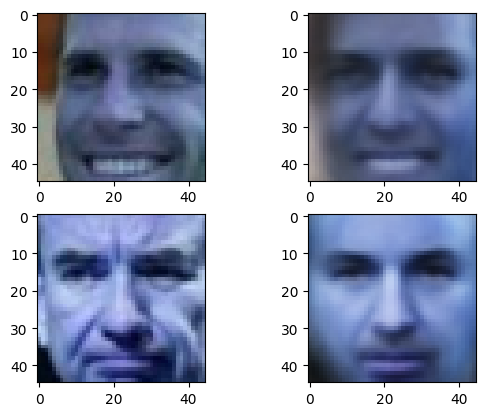

1000/1000 [==============================] - 4s 4ms/step - loss: 66.1869 - reconstruction_loss: 46.5064 - kl_loss: 19.6805 - val_loss: 64.3890 - val_reconstruction_loss: 45.2308 - val_kl_loss: 19.1581
Epoch 10/50
1000/1000 [==============================] - 4s 4ms/step - loss: 65.7147 - reconstruction_loss: 46.4088 - kl_loss: 19.3059 - val_loss: 64.6667 - val_reconstruction_loss: 45.6109 - val_kl_loss: 19.0558
Epoch 11/50
 988/1000 [============================>.] - ETA: 0s - loss: 65.4621 - reconstruction_loss: 46.3560 - kl_loss: 19.1061

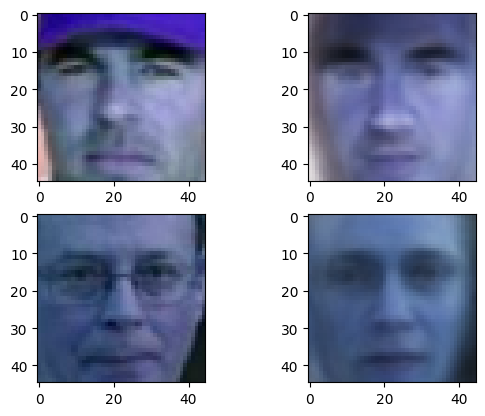

1000/1000 [==============================] - 4s 4ms/step - loss: 65.4490 - reconstruction_loss: 46.3432 - kl_loss: 19.1058 - val_loss: 64.1084 - val_reconstruction_loss: 44.8546 - val_kl_loss: 19.2538
Epoch 12/50
1000/1000 [==============================] - 4s 4ms/step - loss: 64.6535 - reconstruction_loss: 45.8859 - kl_loss: 18.7676 - val_loss: 62.6775 - val_reconstruction_loss: 43.6613 - val_kl_loss: 19.0162
Epoch 13/50
 999/1000 [============================>.] - ETA: 0s - loss: 64.0908 - reconstruction_loss: 45.4634 - kl_loss: 18.6274

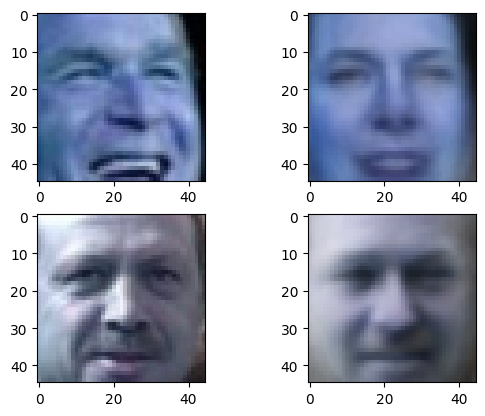

1000/1000 [==============================] - 5s 5ms/step - loss: 64.0735 - reconstruction_loss: 45.4485 - kl_loss: 18.6250 - val_loss: 62.9335 - val_reconstruction_loss: 43.4555 - val_kl_loss: 19.4780
Epoch 14/50
1000/1000 [==============================] - 4s 4ms/step - loss: 64.0996 - reconstruction_loss: 45.4957 - kl_loss: 18.6038 - val_loss: 63.1680 - val_reconstruction_loss: 45.4832 - val_kl_loss: 17.6848
Epoch 15/50
 986/1000 [============================>.] - ETA: 0s - loss: 63.5297 - reconstruction_loss: 45.0502 - kl_loss: 18.4794

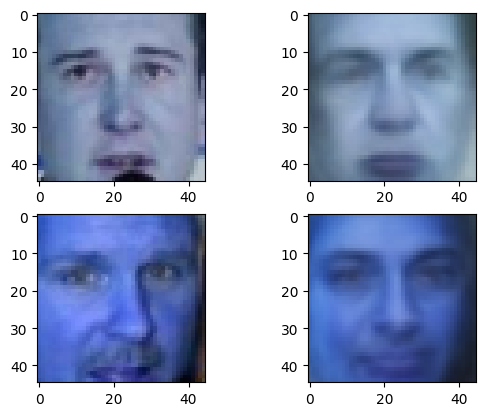

1000/1000 [==============================] - 4s 4ms/step - loss: 63.5254 - reconstruction_loss: 45.0487 - kl_loss: 18.4767 - val_loss: 61.7126 - val_reconstruction_loss: 43.2661 - val_kl_loss: 18.4464
Epoch 16/50
1000/1000 [==============================] - 5s 5ms/step - loss: 63.3954 - reconstruction_loss: 45.0000 - kl_loss: 18.3954 - val_loss: 63.1977 - val_reconstruction_loss: 43.0528 - val_kl_loss: 20.1449
Epoch 17/50
 995/1000 [============================>.] - ETA: 0s - loss: 62.9081 - reconstruction_loss: 44.5664 - kl_loss: 18.3417

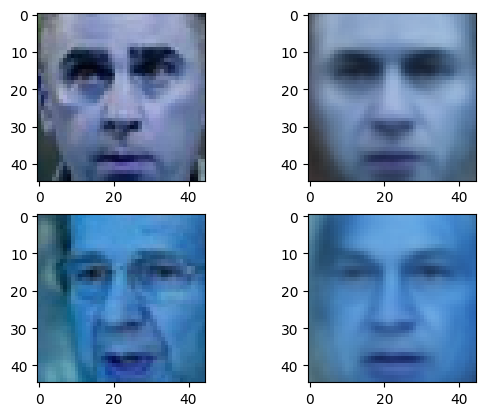

1000/1000 [==============================] - 4s 4ms/step - loss: 62.9161 - reconstruction_loss: 44.5756 - kl_loss: 18.3405 - val_loss: 64.3330 - val_reconstruction_loss: 43.9047 - val_kl_loss: 20.4284
Epoch 18/50
1000/1000 [==============================] - 4s 4ms/step - loss: 62.7947 - reconstruction_loss: 44.5253 - kl_loss: 18.2694 - val_loss: 61.8522 - val_reconstruction_loss: 43.0416 - val_kl_loss: 18.8107
Epoch 19/50
 991/1000 [============================>.] - ETA: 0s - loss: 62.6749 - reconstruction_loss: 44.4190 - kl_loss: 18.2558

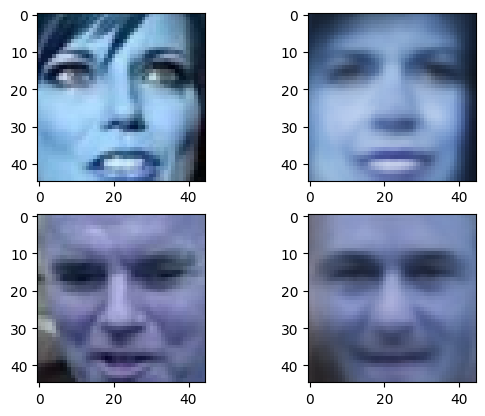

1000/1000 [==============================] - 5s 5ms/step - loss: 62.6733 - reconstruction_loss: 44.4169 - kl_loss: 18.2565 - val_loss: 61.8284 - val_reconstruction_loss: 44.3287 - val_kl_loss: 17.4997
Epoch 20/50
1000/1000 [==============================] - 4s 4ms/step - loss: 62.3852 - reconstruction_loss: 44.1689 - kl_loss: 18.2163 - val_loss: 61.8264 - val_reconstruction_loss: 44.2795 - val_kl_loss: 17.5469


In [11]:
history = vae.fit(
    X_train,
    validation_data=(X_val, X_val),
    epochs=50,
    batch_size=10,
    callbacks=[callback, early_stop]
)

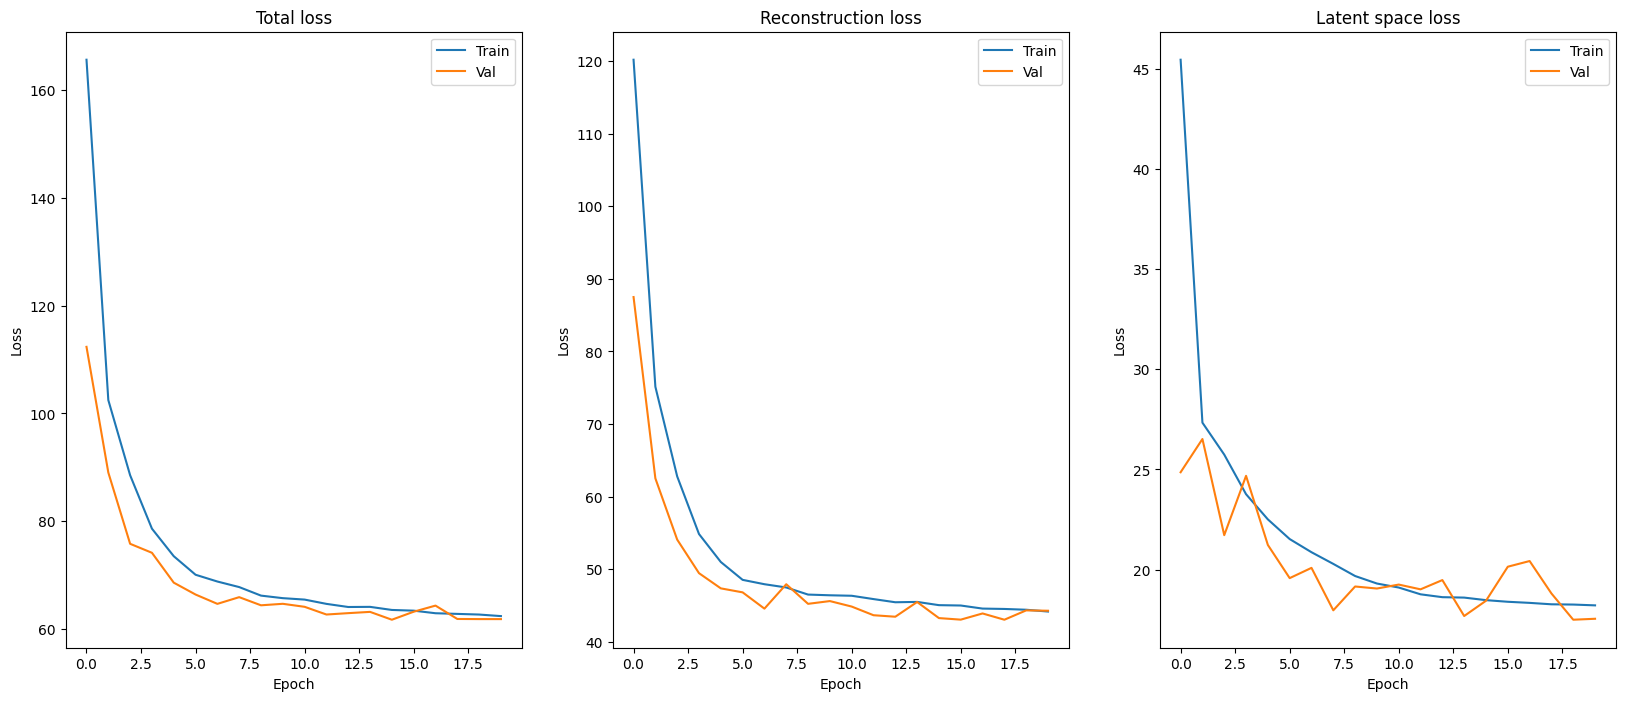

In [13]:
plt.figure(figsize=(20, 8))
plt.subplot(131)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Total loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])

plt.subplot(132)
plt.plot(history.history['reconstruction_loss'])
plt.plot(history.history['val_reconstruction_loss'])
plt.title('Reconstruction loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])

plt.subplot(133)
plt.plot(history.history['kl_loss'])
plt.plot(history.history['val_kl_loss'])
plt.title('Latent space loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])
plt.show()

And finally sample from VAE.

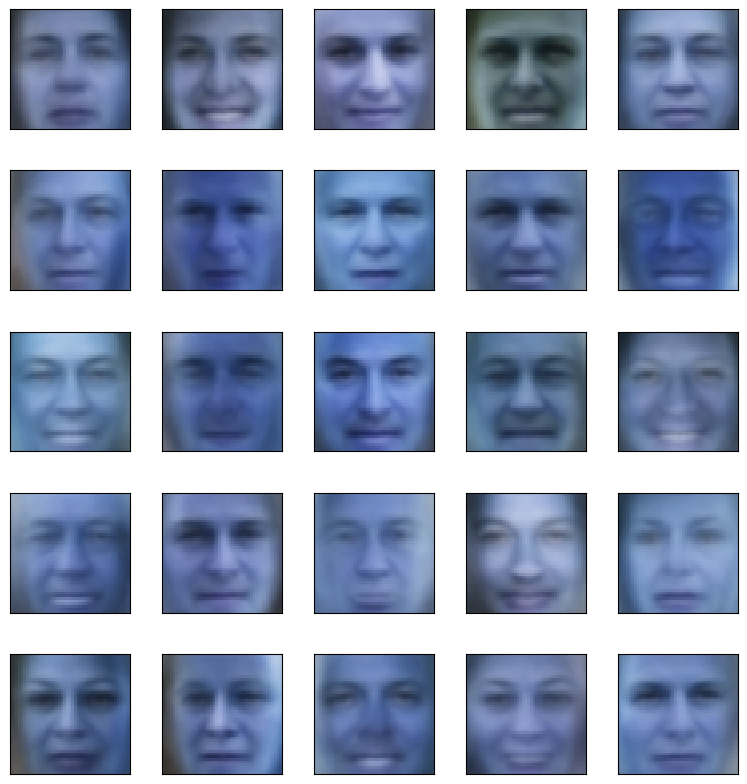

In [24]:
# TODO
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))
z = np.random.randn(25, dimZ) * 0.5
output = decoder(z).numpy()
plot_gallery(output, image_h, image_w, n_row=5, n_col=5)

# Congrats! and Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE.

<img src="linear.png" alt="linear">

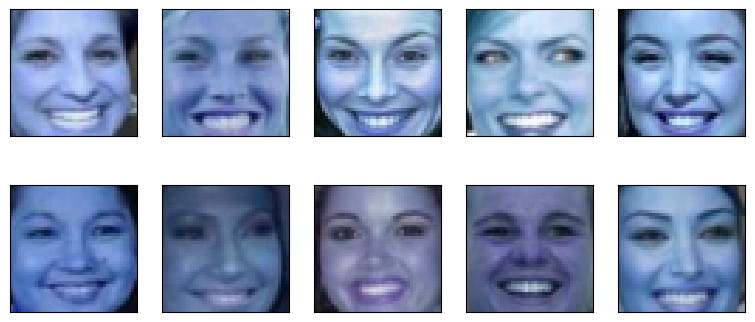

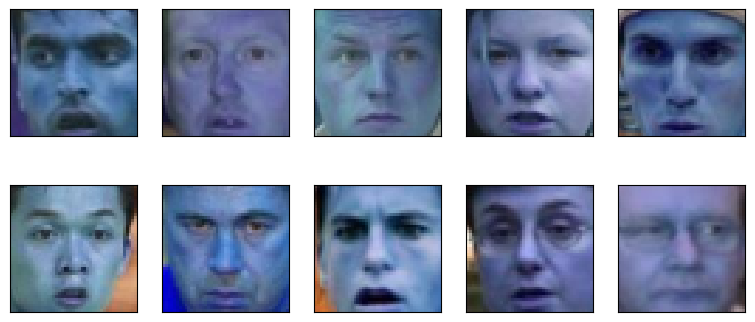

In [28]:
sorted_smiling = attrs.Smiling.argsort().values
idx_smiling = sorted_smiling[-10:][::-1]
idx_non_smiling = sorted_smiling[:10]
X_smiling = data[idx_smiling] / 255.0
X_non_smiling = data[idx_non_smiling] / 255.0
plot_gallery(X_smiling, image_h, image_w, n_row=2, n_col=5)
plot_gallery(X_non_smiling, image_h, image_w, n_row=2, n_col=5)

In [29]:
smile_mean, smile_log_var, smile = encoder(X_smiling.reshape(10, -1))
smile_mean = smile_mean.numpy().mean(axis=0)
smile_log_var = smile_log_var.numpy().mean(axis=0)
smile = smile.numpy().mean(axis=0)
non_smile_mean, non_smile_log_var, non_smile = encoder(X_non_smiling.reshape(10, -1))
non_smile_mean = non_smile_mean.numpy().mean(axis=0)
non_smile_log_var = non_smile_log_var.numpy().mean(axis=0)
non_smile = non_smile.numpy().mean(axis=0)
diff_mean = smile_mean - non_smile_mean
diff_log_var = smile_log_var - non_smile_log_var
diff = smile - non_smile

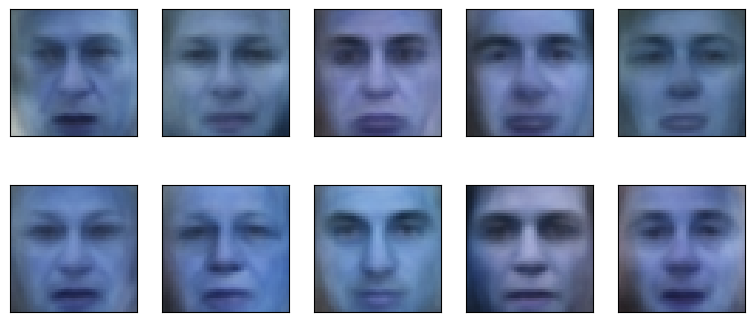

In [32]:
z = np.random.randn(10, dimZ)
output = decoder(non_smile_mean + np.exp(0.5 * non_smile_log_var) * z).numpy()
plot_gallery(output, image_h, image_w, n_row=2, n_col=5)

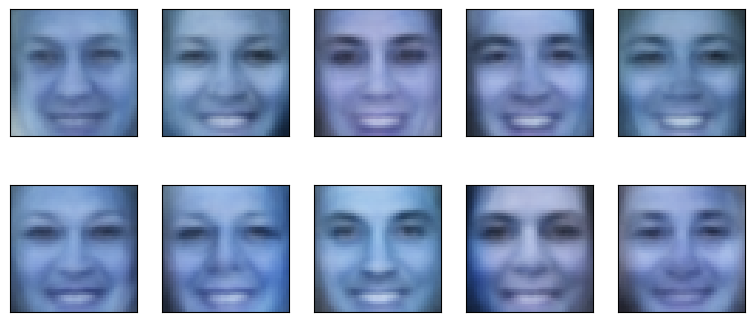

In [33]:
smiling_output = decoder(smile_mean + np.exp(0.5 * smile_log_var) * z).numpy()
plot_gallery(smiling_output, image_h, image_w, n_row=2, n_col=5)